#RANSAC Algorithm


1.   Generate a 2D dataset with a noisy line (using e.g. Gauss noise or a noise of another distribution)

2.   Create a code in Python (or use an existing library) that detects the line parameters (e.g., a and b  coefficients of  y = ax + b line model) using RANSAC algorithm

3.   Visualize the RANSAC-based line detection

4.   Compare with linear regression model



Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


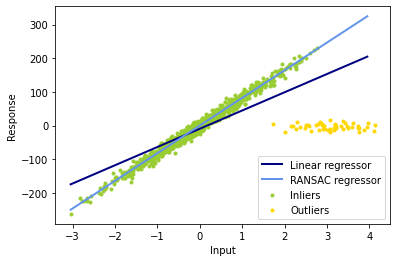

In [30]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(
    n_samples=n_samples,
    n_features=1,
    n_informative=1,
    noise=10,
    coef=True,
    random_state=0,
)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=2, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=2,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

#Point Cloud
Detect & visualize an object from 3D point cloud by eliminating the environment, and estimate the distance to the object

##Data Loading and Visualization

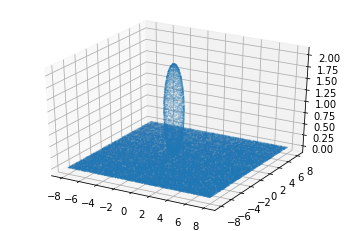

In [31]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.express as px

pcd = np.loadtxt("ball.xyz",skiprows=1)
xyz=pcd[:,:3]

ax = plt.axes(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], s=0.01)
plt.show()

In [32]:
#Interactive view for the point cloud
fig = px.scatter_3d(x=xyz[:,0], y=xyz[:,1], z=xyz[:,2] )
fig.show()

##RANSAC Function

We create the RANSAC loop over the iteration parameter. For each loop, we will compute the best fitting RANSAC plane, and retain both the equation and the inliers indexes.

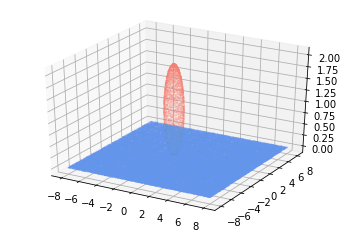


 
 
aproximate object position   X= -0.5841646133318834   Y= 1.0141082018877774   Z= 0.014401500393649416


In [35]:
#reference: https://towardsdatascience.com/3d-model-fitting-for-point-clouds-with-ransac-and-python-2ab87d5fd363

def ransac_plane(xyz, threshold=0.05, iterations=1000):
  inliers=[]
  n_points=len(xyz)
  i=1
  while i<iterations:
    #take 3 random ponits from the pointcloud
    idx_samples = random.sample(range(n_points), 3)
    pts = xyz[idx_samples]
    # find two vectors from the same point
    vecA = pts[1] - pts[0]
    vecB = pts[2] - pts[0]
    normal = np.cross(vecA, vecB)
    a,b,c = normal / np.linalg.norm(normal)
    d=-np.sum(normal*pts[1])

    distance = (a * xyz[:,0] + b * xyz[:,1] + c * xyz[:,2] + d) / np.sqrt(a ** 2 + b ** 2 + c ** 2) #calculate distance

    ## check distances less than the threshold            
    idx_candidates = np.where(np.abs(distance) <= threshold)[0]
    ## store in the inliers and save equation of the plane 
    if len(idx_candidates) > len(inliers):
      equation = [a,b,c,d]
      inliers = idx_candidates
    
    i+=1
  return equation, inliers


eq,idx_inliers=ransac_plane(xyz,0.01)
inliers=xyz[idx_inliers]

# seperate plane points from the object 
mask = np.ones(len(xyz), dtype=bool)
mask[idx_inliers] = False 
outliers=xyz[mask]

#plot the output
ax = plt.axes(projection='3d')
ax.scatter(inliers[:,0], inliers[:,1], inliers[:,2], c = 'cornflowerblue', s=0.02)
ax.scatter(outliers[:,0], outliers[:,1], outliers[:,2], c = 'salmon', s=0.02)
plt.show()

#calculate position
X=np.mean(outliers[:,0])
Y=np.mean(outliers[:,2])
Z=np.mean(outliers[:,1])

print("\n \n \naproximate object position "," X=",X,"  Y=",Y,"  Z=",Z)

Code and data can be found on [GitHub](https://github.com/ahmad12hamdan99/SPA.git)